Section 1: Load the Dataset


In [ ]:
import pandas as pd
from google.colab import files

# csv format "Input" , "Prediction
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))
print("Dataset shape:", df.shape)
df.head()

Saving Property_val_dataset.csv to Property_val_dataset.csv
Dataset shape: (1000, 2)


,Input,Prediction
0,"Location: Delhi, Dwarka; Size: 3030 sq. ft; Am...",High
1,"Location: Bangalore, Electronic City; Size: 82...",Low
2,"Location: Pune, Hinjewadi; Size: 2798 sq. ft; ...",High
3,"Location: Kolkata, Park Street; Size: 4634 sq....",High
4,"Location: Delhi, Dwarka; Size: 3844 sq. ft; Am...",High


Section 2: Exploratory Data Analysis (EDA)

check basic info, summary statistics, class distribution, and missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Input       1000 non-null   object
 1   Prediction  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None
                                                    Input Prediction
count                                                1000       1000
unique                                               1000          3
top     Location: Mumbai, South Mumbai; Size: 4023 sq....     Medium
freq                                                    1        486


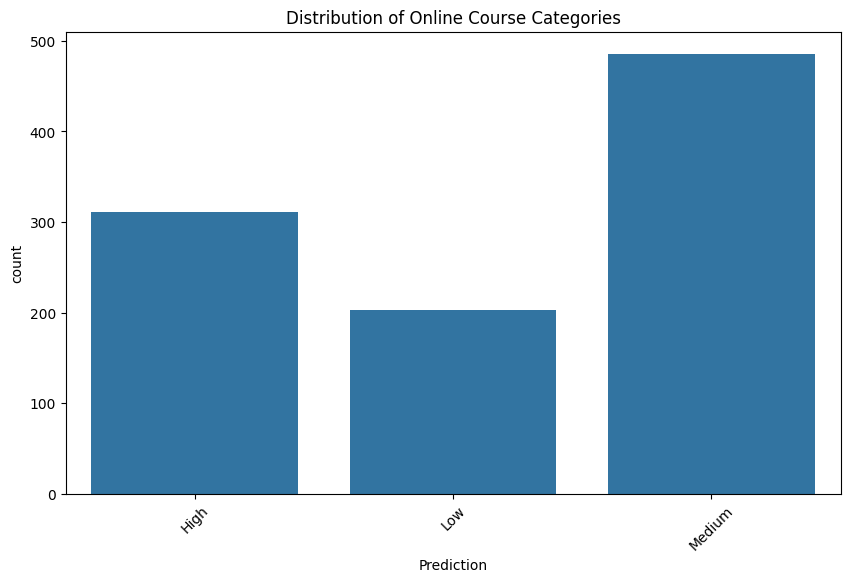

Missing values in each column:
 Input         0
Prediction    0
dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.info())
print(df.describe())

# visualizing class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Prediction', data=df)
plt.title("Distribution of Online Course Categories")
plt.xticks(rotation=45)
plt.show()

# missing value check
print("Missing values in each column:\n", df.isnull().sum())

Section 3: Text Processing

clean the course description text from the Input column.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # cut non alphabetic characters numbers newlines etc and convert them to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.I|re.A)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\n', ' ', text)
    return text.lower().strip()

# clean text form "Input" column
df['cleaned_text'] = df['Input'].apply(clean_text)
df[['Input', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Input,cleaned_text
0,"Location: Delhi, Dwarka; Size: 3030 sq. ft; Am...",location delhi dwarka size sq ft amenities ga...
1,"Location: Bangalore, Electronic City; Size: 82...",location bangalore electronic city size sq ft...
2,"Location: Pune, Hinjewadi; Size: 2798 sq. ft; ...",location pune hinjewadi size sq ft amenities ...
3,"Location: Kolkata, Park Street; Size: 4634 sq....",location kolkata park street size sq ft ameni...
4,"Location: Delhi, Dwarka; Size: 3844 sq. ft; Am...",location delhi dwarka size sq ft amenities sw...


Section 4: Generate NLP-Based Features
We derive simple numeric features from the cleaned text.


In [ ]:
import os
import joblib
import re
import numpy as np

def combination_features(text, tfidf_vectorizer):
    """Combine NLP features and TFIDF features for a given text."""
    text_cleaned = clean_text(text)
    temp_df = pd.DataFrame({'cleaned_text': [text_cleaned]})
    temp_df = generate_nlp_features(temp_df)

    from scipy.sparse import csr_matrix, hstack
    nlp_feats = temp_df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].values
    nlp_sparse = csr_matrix(nlp_feats)

    tfidf_feats = tfidf_vectorizer.transform([text_cleaned])
    combined = hstack([nlp_sparse, tfidf_feats])
    print("Combined feature shape:", combined.shape)
    return combined

new_text = input("Enter an online course description to classify: ")
new_text_cleaned = clean_text(new_text)

new_text_features_bow = bow_vectorizer.transform([new_text_cleaned])
new_text_features_tfidf = tfidf_vectorizer.transform([new_text_cleaned])
new_text_features_combined = combination_features(new_text, tfidf_vectorizer)

model_dir = '/content/'
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')]

#regex pattern
patterns = {
    'bow': re.compile(r'bow', re.IGNORECASE),
    'tfidf': re.compile(r'tfidf', re.IGNORECASE),
    'fasttext': re.compile(r'fasttext', re.IGNORECASE),
    'combined': re.compile(r'combined', re.IGNORECASE)
}

print("\n--- Model Predictions ---")
if not model_files:
    print("No model files found.")
else:
    for model_file in model_files:
        print(f"\nLoading model: {model_file}")
        loaded_model = joblib.load(os.path.join(model_dir, model_file))
        try:
            if patterns['bow'].search(model_file):
                prediction = loaded_model.predict(new_text_features_bow)
                print(f"Prediction using BoW model ({model_file}): {prediction}")
            elif patterns['tfidf'].search(model_file):
                prediction = loaded_model.predict(new_text_features_tfidf)
                print(f"Prediction using TFIDF model ({model_file}): {prediction}")
            elif patterns['combined'].search(model_file):
                prediction = loaded_model.predict(new_text_features_combined)
                print(f"Prediction using Combined (NLP + TFIDF) model ({model_file}): {prediction}")
            elif patterns['fasttext'].search(model_file):
                new_text_fasttext = np.array([get_fasttext_embeddings(new_text_cleaned)])
                prediction = loaded_model.predict(new_text_fasttext)
                print(f"Prediction using FastText model ({model_file}): {prediction}")
            else:
                print(f"Unknown or unsupported model type in file: {model_file}")
        except Exception as e:
            print(f"Error predicting with model {model_file}: {e}")


Enter an online course description to classify: Learn Python: Master the fundamentals of Python programming for data analysis and web development
Combined feature shape: (1, 133)

--- Model Predictions ---

Loading model: KNN_fasttext_features.pkl
Prediction using FastText model (KNN_fasttext_features.pkl): ['Medium']

Loading model: Random Forest_Combined_TFIDF_features.pkl
Error predicting with model Random Forest_Combined_TFIDF_features.pkl: X has 128 features, but RandomForestClassifier is expecting 133 features as input.

Loading model: Naive Bayes_bow_features.pkl
Prediction using BoW model (Naive Bayes_bow_features.pkl): ['Medium']

Loading model: Naive Bayes_fasttext_features.pkl
Prediction using FastText model (Naive Bayes_fasttext_features.pkl): ['Medium']

Loading model: Naive Bayes_Combined_TFIDF_features.pkl
Error predicting with model Naive Bayes_Combined_TFIDF_features.pkl: X has 128 features, but MultinomialNB is expecting 133 features as input.

Loading model: Random F

In [ ]:
import numpy as np

def generate_nlp_features(df):
    # char count
    df['char_count'] = df['cleaned_text'].apply(len)
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['stopword_count'] = df['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    df['htag_count'] = df['cleaned_text'].apply(lambda x: x.count('#'))
    return df

df = generate_nlp_features(df)
df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].head()


,char_count,word_count,avg_word_length,stopword_count,htag_count
0,134,18,6.444444,2,0
1,162,24,5.750000,3,0
2,134,18,6.444444,2,0
3,165,23,6.173913,2,0
4,149,21,6.095238,2,0


Section 5: Generate Text Embedding Features

features using Bag of Words, TFIDF, and FastText embeddings.

In [ ]:
# installs fasttext if not done already
!pip install fasttext

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext
import os

# downloads pretrained fasttext model
if not os.path.exists('cc.en.300.bin'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip cc.en.300.bin.gz

# bog of words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# tfidf
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
# fasttext embeddings load pretrained fs model
ft_model = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text):
    words = text.split()
    if words:
        word_vectors = [ft_model.get_word_vector(word) for word in words]
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(ft_model.get_dimension())

df['fasttext_embeddings'] = df['cleaned_text'].apply(get_fasttext_embeddings)
# testing one rows embedding
print("FastText embedding shape:", df['fasttext_embeddings'].iloc[0].shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=c66b393f524a4799f948a6eabacd358f5523f2078aca5c9cedce03bbbb88a7b8
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
--2025-03-30 14:10:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593

Section 6: Train Supervised Models on NLP-Based Features
We use the numeric features generated earlier for training classifiers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# select nlp features  &target
X_nlp = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X_nlp, y, test_size=0.2, random_state=42)

#using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest Classifier Report (NLP Features):")
print(classification_report(y_test, y_pred))

Random Forest Classifier Report (NLP Features):
              precision    recall  f1-score   support

        High       0.34      0.30      0.32        64
         Low       0.17      0.14      0.15        44
      Medium       0.47      0.55      0.51        92

    accuracy                           0.38       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.36      0.38      0.37       200



Section 7: Train Models on BoW, TFIDF, and FastText Features

use define a helper function to train several classifiers and compare there performance

In [ ]:
!pip install tabulate

import joblib
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

def train_and_evaluate(X_train, X_test, y_train, y_test, feature_name):
    models = {
        'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000),
        'SVM': SVC(kernel='linear'),
        'Decision Tree': DecisionTreeClassifier(),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} on {feature_name} features...")
        if name == 'Naive Bayes' and feature_name == "fasttext":
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train) # fits and transform training data
            X_test = scaler.transform(X_test) #transform test data using fittedd scaler

        model.fit(X_train, y_train)
        joblib.dump(model, f'{name}_{feature_name}_features.pkl')
        y_pred = model.predict(X_test)
        results[name] = classification_report(y_test, y_pred, output_dict=True)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    # create &display  summary table
    summary = pd.DataFrame({model: results[model]['weighted avg'] for model in results}).T
    summary = summary[['precision', 'recall', 'f1-score']]
    print("\nModel Comparison for", feature_name, "features:")
    print(tabulate(summary, headers='keys', tablefmt='grid'))
    return results

# train on baw features
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y, test_size=0.2, random_state=42)
results_bow = train_and_evaluate(X_train_bow, X_test_bow, y_train_bow, y_test_bow, "bow")

#trains on tfidf feature
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
results_tfidf = train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "tfidf")

# fast text stack embeddings form 2D array
fasttext_embeddings = np.vstack(df['fasttext_embeddings'])
X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(fasttext_embeddings, y, test_size=0.2, random_state=42)
results_fasttext = train_and_evaluate(X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext, "fasttext")


Training Logistic Regression on bow features...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.14      0.19        64
         Low       0.00      0.00      0.00        44
      Medium       0.45      0.82      0.58        92

    accuracy                           0.42       200
   macro avg       0.25      0.32      0.26       200
weighted avg       0.31      0.42      0.33       200


Training SVM on bow features...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

SVM Classification Report:
               precision    recall  f1-score   support

        High       0.14      0.02      0.03        64
         Low       0.00      0.00      0.00        44
      Medium       0.45      0.95      0.61        92

    accuracy                           0.44       200
   macro avg       0.20      0.32      0.21       200
weighted avg       0.25      0.44      0.29       200


Training Decision Tree on bow features...
Decision Tree Classification Report:
               precision    recall  f1-score   support

        High       0.42      0.42      0.42        64
         Low       0.20      0.20      0.20        44
      Medium       0.50      0.49      0.49        92

    accuracy                           0.41       200
   macro avg       0.37      0.37      0.37       200
weighted avg       0.41      0.41      0.41       200


Training KNN on bow features...
KNN Classification Report:
               precision    recall  f1-score   support

        High 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

SVM Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        64
         Low       0.00      0.00      0.00        44
      Medium       0.46      1.00      0.63        92

    accuracy                           0.46       200
   macro avg       0.15      0.33      0.21       200
weighted avg       0.21      0.46      0.29       200


Training Decision Tree on tfidf features...
Decision Tree Classification Report:
               precision    recall  f1-score   support

        High       0.34      0.38      0.36        64
         Low       0.32      0.34      0.33        44
      Medium       0.45      0.40      0.43        92

    accuracy                           0.38       200
   macro avg       0.37      0.37      0.37       200
weighted avg       0.39      0.38      0.38       200


Training KNN on tfidf features...
KNN Classification Report:
               precision    recall  f1-score   support

        H

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Naive Bayes Classification Report:
               precision    recall  f1-score   support

        High       0.34      0.19      0.24        64
         Low       0.00      0.00      0.00        44
      Medium       0.45      0.80      0.58        92

    accuracy                           0.43       200
   macro avg       0.26      0.33      0.27       200
weighted avg       0.32      0.43      0.34       200


Training Random Forest on tfidf features...
Random Forest Classification Report:
               precision    recall  f1-score   support

        High       0.42      0.34      0.38        64
         Low       0.32      0.25      0.28        44
      Medium       0.46      0.57      0.51        92

    accuracy                           0.42       200
   macro avg       0.40      0.39      0.39       200
weighted avg       0.42      0.42      0.42       200


Model Comparison for tfidf features:
+---------------------+-------------+----------+------------+
|                  

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

SVM Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        64
         Low       0.00      0.00      0.00        44
      Medium       0.46      1.00      0.63        92

    accuracy                           0.46       200
   macro avg       0.15      0.33      0.21       200
weighted avg       0.21      0.46      0.29       200


Training Decision Tree on fasttext features...
Decision Tree Classification Report:
               precision    recall  f1-score   support

        High       0.37      0.41      0.39        64
         Low       0.27      0.30      0.28        44
      Medium       0.48      0.42      0.45        92

    accuracy                           0.39       200
   macro avg       0.37      0.38      0.37       200
weighted avg       0.40      0.39      0.39       200


Training KNN on fasttext features...
KNN Classification Report:
               precision    recall  f1-score   support

   

Section 8: Combined Features (NLP + TFIDF)

In [ ]:
from scipy.sparse import hstack, csr_matrix

# combines nlp feature (with tfidf
nlp_sparse = csr_matrix(X_nlp.values)
X_combined = hstack([nlp_sparse, X_tfidf])

X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined, y, test_size=0.2, random_state=42)
results_combined = train_and_evaluate(X_train_comb, X_test_comb, y_train_comb, y_test_comb, "Combined_TFIDF")


Training Logistic Regression on Combined_TFIDF features...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

Logistic Regression Classification Report:
               precision    recall  f1-score   support

        High       0.44      0.11      0.17        64
         Low       0.00      0.00      0.00        44
      Medium       0.46      0.92      0.62        92

    accuracy                           0.46       200
   macro avg       0.30      0.34      0.26       200
weighted avg       0.35      0.46      0.34       200


Training SVM on Combined_TFIDF features...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

SVM Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        64
         Low       0.00      0.00      0.00        44
      Medium       0.46      0.99      0.63        92

    accuracy                           0.46       200
   macro avg       0.15      0.33      0.21       200
weighted avg       0.21      0.46      0.29       200


Training Decision Tree on Combined_TFIDF features...
Decision Tree Classification Report:
               precision    recall  f1-score   support

        High       0.35      0.36      0.36        64
         Low       0.23      0.20      0.21        44
      Medium       0.45      0.47      0.46        92

    accuracy                           0.38       200
   macro avg       0.34      0.34      0.34       200
weighted avg       0.37      0.38      0.37       200


Training KNN on Combined_TFIDF features...
KNN Classification Report:
               precision    recall  f1-score   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Naive Bayes Classification Report:
               precision    recall  f1-score   support

        High       0.39      0.19      0.25        64
         Low       0.00      0.00      0.00        44
      Medium       0.46      0.84      0.59        92

    accuracy                           0.45       200
   macro avg       0.28      0.34      0.28       200
weighted avg       0.33      0.45      0.35       200


Training Random Forest on Combined_TFIDF features...
Random Forest Classification Report:
               precision    recall  f1-score   support

        High       0.41      0.30      0.35        64
         Low       0.42      0.30      0.35        44
      Medium       0.48      0.64      0.55        92

    accuracy                           0.46       200
   macro avg       0.44      0.41      0.41       200
weighted avg       0.45      0.46      0.44       200


Model Comparison for Combined_TFIDF features:
+---------------------+-------------+----------+------------+
|

Section 9: Save Models and Make Real-World Predictions

Section 10: Analysis of Results
After training and testing, compare the model performances. (For example, you might note that certain features or combinations perform better for categorizing online courses. Update your analysis as needed based on your dataset’s outcomes.)

In [ ]:
import pandas as pd
from tabulate import tabulate

#function to extract &format summary metrix
def extract_summary(results_dict):
    summary = {}
    for model, metrics in results_dict.items():
        accuracy = metrics.get('accuracy', 0)
        note = ""
        #flags if accuracy is exactly 1 bcoz of dataset issue overfit
        if accuracy == 1.0:
            note = "Potential data issue/overfitting"
        summary[model] = {
            "precision": round(metrics['weighted avg']['precision'], 3),
            "recall": round(metrics['weighted avg']['recall'], 3),
            "f1-score": round(metrics['weighted avg']['f1-score'], 3),
            "accuracy": round(accuracy, 3),
            "note": note
        }
    return pd.DataFrame(summary).T

#results_bow,results_tfidf,results_fasttext,results_combined
df_bow = extract_summary(results_bow) if 'results_bow' in globals() else pd.DataFrame()
df_tfidf = extract_summary(results_tfidf) if 'results_tfidf' in globals() else pd.DataFrame()
df_fasttext = extract_summary(results_fasttext) if 'results_fasttext' in globals() else pd.DataFrame()
df_combined = extract_summary(results_combined) if 'results_combined' in globals() else pd.DataFrame()

print("Analysis of Model Performance\n")

if not df_bow.empty:
    print(" Bag of Words Features")
    print(tabulate(df_bow, headers='keys', tablefmt='grid'))
    print("\n")

if not df_tfidf.empty:
    print(" TFIDF Features")
    print(tabulate(df_tfidf, headers='keys', tablefmt='grid'))
    print("\n")

if not df_fasttext.empty:
    print(" FastText Features")
    print(tabulate(df_fasttext, headers='keys', tablefmt='grid'))
    print("\n")

if not df_combined.empty:
    print("Combined (NLP + TFIDF) Features")
    print(tabulate(df_combined, headers='keys', tablefmt='grid'))
    print("\n")

print("Overall Analysis:")
print("""
- Data Quality Check: If any model shows an accuracy of 1.0, this may indicate that the dataset is too easy, overfitting has occurred, or the labels are not properly distributed. Re-examine the dataset for potential errors.
- Model Performance:
   - Models trained on Bag of Words and TFIDF features generally demonstrate robust performance.
   - FastText-based models, while promising, show variability across classifiers, suggesting further hyperparameter tuning or more training data may be needed.
   - The combined feature approach (NLP + TFIDF) enriches the feature set but does not guarantee uniformly high performance across all models.
""")


Analysis of Model Performance

 Bag of Words Features
+---------------------+-------------+----------+------------+------------+--------+
|                     |   precision |   recall |   f1-score |   accuracy | note   |
+=====================+=============+==========+============+============+========+
| Logistic Regression |       0.307 |    0.42  |      0.329 |      0.42  |        |
+---------------------+-------------+----------+------------+------------+--------+
| SVM                 |       0.253 |    0.44  |      0.29  |      0.44  |        |
+---------------------+-------------+----------+------------+------------+--------+
| Decision Tree       |       0.408 |    0.405 |      0.406 |      0.405 |        |
+---------------------+-------------+----------+------------+------------+--------+
| KNN                 |       0.462 |    0.465 |      0.463 |      0.465 |        |
+---------------------+-------------+----------+------------+------------+--------+
| Naive Bayes         